In [1]:
!pip install portalocker
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 89.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 82.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [14]:
import torch
import json
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt

configs = {
    "train_source_data":"/content/train.en",
    "train_target_data":"/content/train.de",
    "valid_source_data":"/content/val.en",
    "valid_target_data":"/content/val.de",
    "test_source_data": "/content/trimmed_test.en",
    "test_target_data": "/content/trimmed_test.de",
    "source_max_seq_len":256,
    "target_max_seq_len":256,
    "batch_size":50,
    "device":"cuda:0" if torch.cuda.is_available() else "cpu",
    "embedding_dim": 512,
    "n_layers": 6,
    "n_heads": 8,
    "dropout": 0.15,
    "lr":math.exp(-8),
    "n_epochs":100,
    "print_freq": 5,
    "beam_size":3,
    "model_path":"/content/model_transformer_translate_ende.pt",
    "early_stopping":5
}


In [6]:
def read_data(source_file, target_file):
        source_data = open(source_file).read().strip().split("\n")
        target_data = open(target_file).read().strip().split("\n")
        return source_data, target_data

train_src_data, train_trg_data = read_data(configs["train_source_data"], configs["train_target_data"])
valid_src_data, valid_trg_data = read_data(configs["valid_source_data"], configs["valid_target_data"])


# visualize log
def plot_loss(log_path, log_dir):
    log = json.load(open(log_path, "r"))

    plt.figure()
    plt.plot(log["train_loss"], label="train loss")
    plt.plot(log["valid_loss"], label="valid loss")
    plt.title("Loss per epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join(log_dir, "loss_epoch.png"))

    # plot batch loss
    plt.figure()
    lst = log["train_batch_loss"]
    n = int(len(log["train_batch_loss"]) / len(log["valid_batch_loss"]))
    train_batch_loss = [lst[i:i + n][0] for i in range(0, len(lst), n)]
    plt.plot(train_batch_loss, label="train loss")
    plt.plot(log["valid_batch_loss"], label="valid loss")
    plt.title("Loss per batch")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join(log_dir, "loss_batch.png"))

import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer
import re

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from functools import partial
en_tokenizer = get_tokenizer(tokenizer='spacy', language='en_core_web_sm')
de_tokenizer = get_tokenizer(tokenizer='spacy', language='de_core_news_sm')

def preprocess_seq(seq):
        seq = re.sub(
        r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(seq))
        seq = re.sub(r"[ ]+", " ", seq)
        seq = re.sub(r"\!+", "!", seq)
        seq = re.sub(r"\,+", ",", seq)
        seq = re.sub(r"\?+", "?", seq)
        seq = seq.lower()
        return seq

preprocessed_srclist=[]
for english_sentences in train_src_data:
 preprocessed_src=preprocess_seq(english_sentences)
 preprocessed_srclist.append(preprocessed_src)

preprocessed_tgtlist=[]
for german_sentences in train_trg_data:
 preprocessed_tgt=preprocess_seq(german_sentences)
 preprocessed_tgtlist.append(preprocessed_tgt)

val_preprocessed_srclist=[]
for english_sentences in valid_src_data:
 preprocessed_src=preprocess_seq(english_sentences)
 val_preprocessed_srclist.append(preprocessed_src)

val_preprocessed_tgtlist=[]
for german_sentences in valid_trg_data:
 preprocessed_tgt=preprocess_seq(german_sentences)
 val_preprocessed_tgtlist.append(preprocessed_tgt)

en_vocab = build_vocab_from_iterator(map(en_tokenizer, [english for english in preprocessed_srclist]), min_freq=2, specials=["<unk>", "<sos>", "<eos>", "<pad>"])
de_vocab = build_vocab_from_iterator(map(de_tokenizer, [de for de in preprocessed_tgtlist]), min_freq=2, specials=["<unk>", "<sos>", "<eos>", "<pad>"])

en_token2id = en_vocab.get_stoi()
de_token2id = de_vocab.get_stoi()
en_id2token = en_vocab.get_itos()
de_id2token = de_vocab.get_itos()

unk_token_id = 0
sos_token_id = 1
eos_token_id = 2
pad_token_id = 3

def src_encode(src_text):
        source_sentence = [ en_token2id.get(token, en_token2id['<unk>']) for token in en_tokenizer(src_text) ]
        return source_sentence

def tgt_encode(tgt_text):
        target_sentence = [de_token2id['<sos>']] \
        + [ de_token2id.get(token, de_token2id['<unk>']) for token in de_tokenizer(tgt_text) ] \
        + [ de_token2id['<eos>']]
        return target_sentence


def src_decode(ids):
     sentences = []
     sentence = list(map(lambda x: en_id2token[x], ids))
     sentences.append(" ".join(sentence))
     return sentences

train_src_sentences = [ src_encode(eng) for eng in preprocessed_srclist if len(eng) > 0]
train_tgt_sentences = [ tgt_encode(ger) for ger in preprocessed_tgtlist if len(ger) > 0]
val_src_sentences = [ src_encode(eng) for eng in val_preprocessed_srclist if len(eng) > 0]
val_tgt_sentences = [ tgt_encode(ger) for ger in val_preprocessed_tgtlist if len(ger) > 0]
train_sentences = list(zip(train_src_sentences, train_tgt_sentences))
val_sentences = list(zip(val_src_sentences, val_tgt_sentences))
def pad_features(pad_id, s):
     for i in range(len(s)):
      src_padding = np.full(256-len(s[i][0]), pad_id, dtype=int)
      src_features= s[i][0].extend(src_padding)
      tgt_padding = np.full(256-len(s[i][1]), pad_id, dtype=int)
      tgt_features=s[i][1].extend(tgt_padding)
     return s

train_features=pad_features(pad_token_id,train_sentences)
val_features=pad_features(pad_token_id,val_sentences)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [7]:
class TrainTranslateDataset(Dataset):

    def __init__(self, source_tokenizer, target_tokenizer, source_max_seq_len=256, target_max_seq_len=256):
        self.source_tokenizer = source_tokenizer
        self.target_tokenizer = target_tokenizer
        self.source_max_seq_len = source_max_seq_len
        self.target_max_seq_len = target_max_seq_len
        self.sentences=train_features



    def __len__(self):
        return len(self.sentences)

    # create decoder input mask
    def create_decoder_mask(self, seq_len):
        mask = torch.ones(seq_len, seq_len).tril()
        return mask

    def __getitem__(self, index):

            tensor_source=torch.tensor(self.sentences[index][0])
            tensor_target=torch.tensor(self.sentences[index][1])
            return {
                "source_ids": tensor_source,
                "target_ids": tensor_target
            }


a=TrainTranslateDataset(source_tokenizer=en_tokenizer, target_tokenizer=de_tokenizer, source_max_seq_len=256, target_max_seq_len=256)
print(a[0])
print(len(a[0]["source_ids"]))

{'source_ids': tensor([  16,   24,   15,   25,  776,   17,   56,   79,  200, 1306,    5,    3,
           3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
           3,    3,    3,

In [8]:
class ValidTranslateDataset(Dataset):

    def __init__(self, source_tokenizer, target_tokenizer, source_max_seq_len=256, target_max_seq_len=256):
        self.source_tokenizer = source_tokenizer
        self.target_tokenizer = target_tokenizer
        self.source_max_seq_len = source_max_seq_len
        self.target_max_seq_len = target_max_seq_len
        self.sentences=val_features



    def __len__(self):
        return len(self.sentences)

    # create decoder input mask
    def create_decoder_mask(self, seq_len):
        mask = torch.ones(seq_len, seq_len).tril()
        return mask

    def __getitem__(self, index):

            tensor_source=torch.tensor(self.sentences[index][0])
            tensor_target=torch.tensor(self.sentences[index][1])
            return {
                "source_ids": tensor_source,
                "target_ids": tensor_target
            }

In [9]:

def main():

    def read_data(source_file, target_file):
        source_data = open(source_file).read().strip().split("\n")
        target_data = open(target_file).read().strip().split("\n")
        return source_data, target_data

    train_src_data, train_trg_data = read_data(configs["train_source_data"], configs["train_target_data"])
    valid_src_data, valid_trg_data = read_data(configs["valid_source_data"], configs["valid_target_data"])

    source_tokenizer = en_tokenizer
    target_tokenizer = de_tokenizer
    train_dataset = TrainTranslateDataset(
        source_tokenizer=source_tokenizer,
        target_tokenizer=target_tokenizer,
        source_max_seq_len=configs["source_max_seq_len"],
        target_max_seq_len=configs["target_max_seq_len"]
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=configs["batch_size"],
        shuffle=False
    )
    for batch in train_loader:
        print(batch["source_ids"])
        print(batch["target_ids"])
        break


if __name__ == "__main__":
    main()

tensor([[ 16,  24,  15,  ...,   3,   3,   3],
        [112,  30,   6,  ...,   3,   3,   3],
        [  4,  52,  33,  ...,   3,   3,   3],
        ...,
        [  4,   9,   6,  ...,   3,   3,   3],
        [  4,   9,  13,  ...,   3,   3,   3],
        [  4,  34, 268,  ...,   3,   3,   3]])
tensor([[ 1, 18, 26,  ...,  3,  3,  3],
        [ 1, 76, 30,  ...,  3,  3,  3],
        [ 1,  5, 66,  ...,  3,  3,  3],
        ...,
        [ 1,  5, 13,  ...,  3,  3,  3],
        [ 1,  5, 13,  ...,  3,  3,  3],
        [ 1,  5, 26,  ...,  3,  3,  3]])


In [66]:
import torch
import torch.nn as nn
import numpy as np
import math
from torch.autograd import Variable

# Embedding the input sequence
class Embedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Embedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, x):
        return self.embedding(x)

# The positional encoding vector
class PositionalEncoder(nn.Module):
    def __init__(self, embedding_dim, max_seq_length=512, dropout=0.1):
        super(PositionalEncoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_seq_length, embedding_dim)
        for pos in range(max_seq_length):
            for i in range(0, embedding_dim, 2):
                pe[pos, i] = math.sin(pos/(10000**(2*i/embedding_dim)))
                pe[pos, i+1] = math.cos(pos/(10000**((2*i+1)/embedding_dim)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x*math.sqrt(self.embedding_dim)
        seq_length = x.size(1)
        pe = Variable(self.pe[:, :seq_length], requires_grad=False).to(x.device)
        # Add the positional encoding vector to the embedding vector
        x = x + pe
        x = self.dropout(x)
        return x

# Self-attention layer
class SelfAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, dropout=0.1):
        super(SelfAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        key_dim = key.size(-1)
        attn = torch.matmul(query / np.sqrt(key_dim), key.transpose(2, 3))
        if mask is not None:
            mask = mask.unsqueeze(1)
            attn = attn.masked_fill(mask == 0, -1e9)
        attn = self.dropout(torch.softmax(attn, dim=-1))
        output = torch.matmul(attn, value)

        return output

# Multi-head attention layer
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.self_attention = SelfAttention(dropout)
        # The number of heads
        self.num_heads = num_heads
        # The dimension of each head
        self.dim_per_head = embedding_dim // num_heads
        # The linear projections
        self.query_projection = nn.Linear(embedding_dim, embedding_dim)
        self.key_projection = nn.Linear(embedding_dim, embedding_dim)
        self.value_projection = nn.Linear(embedding_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, query, key, value, mask=None):
        # Apply the linear projections
        batch_size = query.size(0)
        query = self.query_projection(query)
        key = self.key_projection(key)
        value = self.value_projection(value)
        # Reshape the input
        query = query.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        key = key.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        value = value.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        # Calculate the attention
        scores = self.self_attention(query, key, value, mask)
        # Reshape the output
        output = scores.transpose(1, 2).contiguous().view(batch_size, -1, self.embedding_dim)
        # Apply the linear projection
        output = self.out(output)
        return output

# Norm layer
class Norm(nn.Module):
    def __init__(self, embedding_dim):
        super(Norm, self).__init__()
        self.norm = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        return self.norm(x)


# Transformer encoder layer
class EncoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim=2048, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(embedding_dim, num_heads, dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embedding_dim)
        )
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.norm1 = Norm(embedding_dim)
        self.norm2 = Norm(embedding_dim)

    def forward(self, x, mask=None):
        x2 = self.norm1(x)
        # Add and Muti-head attention
        x = x + self.dropout1(self.self_attention(x2, x2, x2, mask))
        x2 = self.norm2(x)
        x = x + self.dropout2(self.feed_forward(x2))
        return x

# Transformer decoder layer
class DecoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim=2048, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(embedding_dim, num_heads, dropout)
        self.encoder_attention = MultiHeadAttention(embedding_dim, num_heads, dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embedding_dim)
        )
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.norm1 = Norm(embedding_dim)
        self.norm2 = Norm(embedding_dim)
        self.norm3 = Norm(embedding_dim)

    def forward(self, x, memory, source_mask, target_mask):
        x2 = self.norm1(x)
        x = x + self.dropout1(self.self_attention(x2, x2, x2, target_mask))
        x2 = self.norm2(x)
        x = x + self.dropout2(self.encoder_attention(x2, memory, memory, source_mask))
        x2 = self.norm3(x)
        x = x + self.dropout3(self.feed_forward(x2))
        return x

# Encoder transformer
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_seq_len, num_heads, num_layers, dropout=0.1):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        self.layers = nn.ModuleList([EncoderLayer(embedding_dim, num_heads, 2048, dropout) for _ in range(num_layers)])
        self.norm = Norm(embedding_dim)
        self.position_embedding = PositionalEncoder(embedding_dim, max_seq_len, dropout)

    def forward(self, source, source_mask):
        # Embed the source
        x = self.embedding(source)
        # Add the position embeddings
        x = self.position_embedding(x)
        # Propagate through the layers
        for layer in self.layers:
            x = layer(x, source_mask)
        # Normalize
        x = self.norm(x)
        return x

# Decoder transformer
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_seq_len,num_heads, num_layers, dropout=0.1):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        self.layers = nn.ModuleList([DecoderLayer(embedding_dim, num_heads, 2048, dropout) for _ in range(num_layers)])
        self.norm = Norm(embedding_dim)
        self.position_embedding = PositionalEncoder(embedding_dim, max_seq_len, dropout)

    def forward(self, target, memory, source_mask, target_mask):
        # Embed the source
        x = self.embedding(target)
        # Add the position embeddings
        x = self.position_embedding(x)
        # Propagate through the layers
        for layer in self.layers:
            x = layer(x, memory, source_mask, target_mask)
        # Normalize
        x = self.norm(x)
        return x


# Transformers
class Transformer(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, source_max_seq_len, target_max_seq_len, embedding_dim, num_heads, num_layers, dropout=0.1):
        super(Transformer, self).__init__()
        self.source_vocab_size = source_vocab_size
        self.target_vocab_size = target_vocab_size
        self.source_max_seq_len = source_max_seq_len
        self.target_max_seq_len = target_max_seq_len
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout = dropout

        self.encoder = Encoder(source_vocab_size, embedding_dim, source_max_seq_len, num_heads, num_layers, dropout)
        self.decoder = Decoder(target_vocab_size, embedding_dim, target_max_seq_len, num_heads, num_layers, dropout)
        self.final_linear = nn.Linear(embedding_dim, target_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, source, target, source_mask, target_mask):
        # Encoder forward pass
        memory = self.encoder(source, source_mask)
        # Decoder forward pass
        output = self.decoder(target, memory, source_mask, target_mask)
        # Final linear layer
        output = self.dropout(output)
        output = self.final_linear(output)
        return output

    def make_source_mask(self, source_ids, source_pad_id):
        return (source_ids != source_pad_id).unsqueeze(-2)

    def make_target_mask(self, target_ids):
        batch_size, len_target = target_ids.size()
        subsequent_mask = (1 - torch.triu(torch.ones((1, len_target, len_target), device=target_ids.device), diagonal=1)).bool()
        return subsequent_mask

Validating epoch 1/100: 100%|██████████| 21/21 [00:05<00:00,  3.89it/s, loss=3.02]


---- Detect improment and save the best model ----
---- Epoch 1/100 | Train loss: 4.1005 | Valid loss: 3.1517 | Best Valid loss: 3.1517 | Best epoch: 1


Validating epoch 2/100: 100%|██████████| 21/21 [00:05<00:00,  3.86it/s, loss=2.23]


---- Detect improment and save the best model ----
---- Epoch 2/100 | Train loss: 2.9056 | Valid loss: 2.4052 | Best Valid loss: 2.4052 | Best epoch: 2


Validating epoch 3/100: 100%|██████████| 21/21 [00:05<00:00,  3.89it/s, loss=1.94]


---- Detect improment and save the best model ----
---- Epoch 3/100 | Train loss: 2.3534 | Valid loss: 2.0595 | Best Valid loss: 2.0595 | Best epoch: 3


Validating epoch 4/100: 100%|██████████| 21/21 [00:05<00:00,  3.88it/s, loss=1.84]


---- Detect improment and save the best model ----
---- Epoch 4/100 | Train loss: 2.0470 | Valid loss: 1.8933 | Best Valid loss: 1.8933 | Best epoch: 4


Validating epoch 5/100: 100%|██████████| 21/21 [00:05<00:00,  3.88it/s, loss=1.78]


---- Detect improment and save the best model ----
---- Epoch 5/100 | Train loss: 1.8379 | Valid loss: 1.7758 | Best Valid loss: 1.7758 | Best epoch: 5


Validating epoch 6/100: 100%|██████████| 21/21 [00:05<00:00,  3.88it/s, loss=1.69]


---- Detect improment and save the best model ----
---- Epoch 6/100 | Train loss: 1.6793 | Valid loss: 1.6721 | Best Valid loss: 1.6721 | Best epoch: 6


Validating epoch 7/100: 100%|██████████| 21/21 [00:05<00:00,  3.88it/s, loss=1.53]


---- Detect improment and save the best model ----
---- Epoch 7/100 | Train loss: 1.5500 | Valid loss: 1.5938 | Best Valid loss: 1.5938 | Best epoch: 7


Validating epoch 8/100: 100%|██████████| 21/21 [00:05<00:00,  3.89it/s, loss=1.54]


---- Detect improment and save the best model ----
---- Epoch 8/100 | Train loss: 1.4400 | Valid loss: 1.5906 | Best Valid loss: 1.5906 | Best epoch: 8


Validating epoch 9/100: 100%|██████████| 21/21 [00:05<00:00,  3.89it/s, loss=1.48]


---- Detect improment and save the best model ----
---- Epoch 9/100 | Train loss: 1.3458 | Valid loss: 1.5843 | Best Valid loss: 1.5843 | Best epoch: 9


Validating epoch 10/100: 100%|██████████| 21/21 [00:05<00:00,  3.89it/s, loss=1.37]


---- Detect improment and save the best model ----
---- Epoch 10/100 | Train loss: 1.2568 | Valid loss: 1.5344 | Best Valid loss: 1.5344 | Best epoch: 10


Validating epoch 11/100: 100%|██████████| 21/21 [00:05<00:00,  3.89it/s, loss=1.35]


---- Epoch 11/100 | Train loss: 1.1729 | Valid loss: 1.5455 | Best Valid loss: 1.5344 | Best epoch: 10


Validating epoch 12/100: 100%|██████████| 21/21 [00:05<00:00,  3.89it/s, loss=1.32]


---- Epoch 12/100 | Train loss: 1.0966 | Valid loss: 1.5630 | Best Valid loss: 1.5344 | Best epoch: 10


Validating epoch 13/100: 100%|██████████| 21/21 [00:05<00:00,  3.86it/s, loss=1.29]


---- Detect improment and save the best model ----
---- Epoch 13/100 | Train loss: 1.0276 | Valid loss: 1.5338 | Best Valid loss: 1.5338 | Best epoch: 13


Validating epoch 14/100: 100%|██████████| 21/21 [00:05<00:00,  3.88it/s, loss=1.29]


---- Detect improment and save the best model ----
---- Epoch 14/100 | Train loss: 0.9614 | Valid loss: 1.5270 | Best Valid loss: 1.5270 | Best epoch: 14


Validating epoch 15/100: 100%|██████████| 21/21 [00:05<00:00,  3.89it/s, loss=1.24]


---- Epoch 15/100 | Train loss: 0.9008 | Valid loss: 1.5530 | Best Valid loss: 1.5270 | Best epoch: 14


Validating epoch 16/100: 100%|██████████| 21/21 [00:05<00:00,  3.89it/s, loss=1.28]


---- Epoch 16/100 | Train loss: 0.8436 | Valid loss: 1.5762 | Best Valid loss: 1.5270 | Best epoch: 14


Validating epoch 17/100: 100%|██████████| 21/21 [00:05<00:00,  3.89it/s, loss=1.25]


---- Epoch 17/100 | Train loss: 0.7935 | Valid loss: 1.5987 | Best Valid loss: 1.5270 | Best epoch: 14


Validating epoch 18/100: 100%|██████████| 21/21 [00:05<00:00,  3.88it/s, loss=1.37]


---- Epoch 18/100 | Train loss: 0.7409 | Valid loss: 1.6502 | Best Valid loss: 1.5270 | Best epoch: 14


Validating epoch 19/100: 100%|██████████| 21/21 [00:05<00:00,  3.89it/s, loss=1.45]


---- Early stopping ----


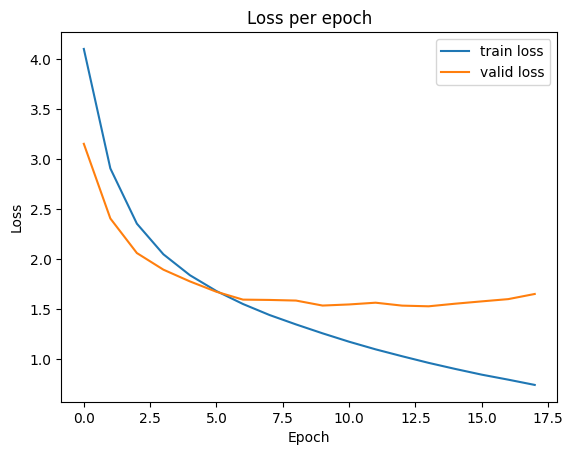

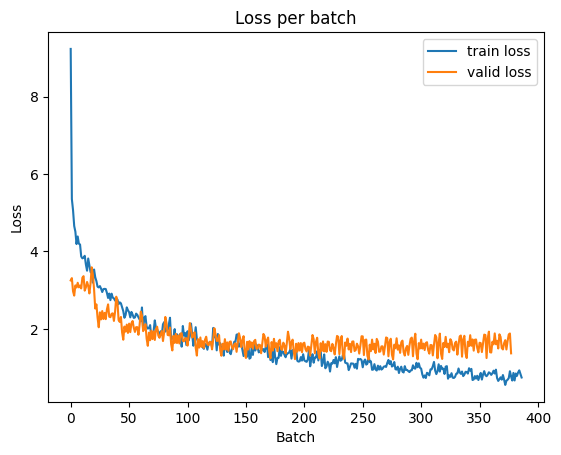

In [15]:
import torch
import torch.nn as nn
import time
import torch.nn.functional as F
from transformers import AutoTokenizer
from tqdm import tqdm
import numpy as np
from datetime import datetime, timedelta
import json
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"





def read_data(source_file, target_file):
    source_data = open(source_file).read().strip().split("\n")
    target_data = open(target_file).read().strip().split("\n")
    return source_data, target_data


def validate_epoch(model, valid_loader, epoch, n_epochs, source_pad_id, target_pad_id, device):
    model.eval()
    total_loss = []
    bar = tqdm(enumerate(valid_loader), total=len(valid_loader), desc=f"Validating epoch {epoch+1}/{n_epochs}")
    for i, batch in bar:
        source, target = batch["source_ids"].to(device), batch["target_ids"].to(device)
        target_input = target[:, :-1]
        source_mask, target_mask = model.make_source_mask(source, source_pad_id), model.make_target_mask(target_input)
        preds = model(source, target_input, source_mask, target_mask)
        gold = target[:, 1:].contiguous().view(-1)
        loss = F.cross_entropy(preds.view(-1, preds.size(-1)), gold, ignore_index=target_pad_id)
        total_loss.append(loss.item())
        bar.set_postfix(loss=total_loss[-1])

    valid_loss = sum(total_loss) / len(total_loss)
    return valid_loss, total_loss


def train_epoch(model, train_loader, optim, epoch, n_epochs, source_pad_id, target_pad_id, device):
    model.train()
    total_loss = []
    bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Training epoch {epoch+1}/{n_epochs}")
    for i, batch in bar:
        source, target = batch["source_ids"].to(device), batch["target_ids"].to(device)
        target_input = target[:, :-1]
        source_mask, target_mask = model.make_source_mask(source, source_pad_id), model.make_target_mask(target_input)
        preds = model(source, target_input, source_mask, target_mask)
        optim.zero_grad()
        gold = target[:, 1:].contiguous().view(-1)
        loss = F.cross_entropy(preds.view(-1, preds.size(-1)), gold, ignore_index=target_pad_id)
        loss.backward()
        optim.step()
        total_loss.append(loss.item())
        bar.set_postfix(loss=total_loss[-1])

    train_loss = sum(total_loss) / len(total_loss)
    return train_loss, total_loss


def train(model, train_loader, valid_loader, optim, n_epochs, source_pad_id, target_pad_id, device, model_path, early_stopping):
    log_dir = "./logs"
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    best_val_loss = np.Inf
    best_epoch = 1
    count_early_stop = 0
    log = {"train_loss": [], "valid_loss": [], "train_batch_loss": [], "valid_batch_loss": []}
    for epoch in range(n_epochs):
        train_loss, train_losses = train_epoch(
            model=model,
            train_loader=train_loader,
            optim=optim,
            epoch=epoch,
            n_epochs=n_epochs,
            source_pad_id=source_pad_id,
            target_pad_id=target_pad_id,
            device=device
        )
        valid_loss, valid_losses = validate_epoch(
            model=model,
            valid_loader=valid_loader,
            epoch=epoch,
            n_epochs=n_epochs,
            source_pad_id=source_pad_id,
            target_pad_id=target_pad_id,
            device=device
        )

        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            best_epoch = epoch + 1
            # save model
            torch.save(model.state_dict(), model_path)
            print("---- Detect improment and save the best model ----")
            count_early_stop = 0
        else:
            count_early_stop += 1
            if count_early_stop >= early_stopping:
                print("---- Early stopping ----")
                break

        torch.cuda.empty_cache()

        log["train_loss"].append(train_loss)
        log["valid_loss"].append(valid_loss)
        log["train_batch_loss"].extend(train_losses)
        log["valid_batch_loss"].extend(valid_losses)
        log["best_epoch"] = best_epoch
        log["best_val_loss"] = best_val_loss
        log["last_epoch"] = epoch + 1

        with open(os.path.join(log_dir, "log.json"), "w") as f:
            json.dump(log, f)

        print(f"---- Epoch {epoch+1}/{n_epochs} | Train loss: {train_loss:.4f} | Valid loss: {valid_loss:.4f} | Best Valid loss: {best_val_loss:.4f} | Best epoch: {best_epoch}")

    return log


def main():
    train_src_data, train_trg_data = read_data(configs["train_source_data"], configs["train_target_data"])
    valid_src_data, valid_trg_data = read_data(configs["valid_source_data"], configs["valid_target_data"])
    source_tokenizer = en_tokenizer
    target_tokenizer = de_tokenizer

    model = Transformer(
        source_vocab_size=10000,
        target_vocab_size=10000,
        embedding_dim=configs["embedding_dim"],
        source_max_seq_len=configs["source_max_seq_len"],
        target_max_seq_len=configs["target_max_seq_len"],
        num_layers=configs["n_layers"],
        num_heads=configs["n_heads"],
        dropout=configs["dropout"]
    )

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    optim = torch.optim.Adam(model.parameters(), lr=configs["lr"], betas=(0.9, 0.98), eps=1e-9)

    train_dataset = TrainTranslateDataset(
        source_tokenizer=source_tokenizer,
        target_tokenizer=target_tokenizer,
        source_max_seq_len=configs["source_max_seq_len"],
        target_max_seq_len=configs["target_max_seq_len"],
    )
    valid_dataset = ValidTranslateDataset(
        source_tokenizer=source_tokenizer,
        target_tokenizer=target_tokenizer,
        source_max_seq_len=configs["source_max_seq_len"],
        target_max_seq_len=configs["target_max_seq_len"],
    )

    device = torch.device(configs["device"])
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=configs["batch_size"],
        shuffle=True
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=configs["batch_size"],
        shuffle=False
    )

    model.to(configs["device"])
    train(model=model,
        train_loader=train_loader,
        valid_loader=valid_loader,
        optim=optim,
        n_epochs=configs["n_epochs"],
        source_pad_id=pad_token_id,
        target_pad_id=pad_token_id,
        device=device,
        model_path=configs["model_path"],
        early_stopping=configs["early_stopping"]
    )

    plot_loss(log_path="./logs/log.json", log_dir="./logs")

if __name__ == "__main__":
    main()

In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import re
import json
from tqdm import tqdm
from torchtext.data.metrics import bleu_score

from nltk.translate.bleu_score import corpus_bleu



def tgt_decode(ids):
        sentence = list(map(lambda x: de_id2token[x], ids))[1:-1]
        return " ".join(sentence)


def load_model_tokenizer(configs):
    """
    This function will load model and tokenizer from pretrained model and tokenizer
    """
    device = torch.device(configs["device"])
    source_tokenizer = en_tokenizer
    target_tokenizer = de_tokenizer

    # Load model Transformer
    model = Transformer(
        source_vocab_size=10000,
        target_vocab_size=10000,
        embedding_dim=configs["embedding_dim"],
        source_max_seq_len=configs["source_max_seq_len"],
        target_max_seq_len=configs["target_max_seq_len"],
        num_layers=configs["n_layers"],
        num_heads=configs["n_heads"],
        dropout=configs["dropout"]
    )
    model.load_state_dict(torch.load(configs["model_path"],map_location=torch.device('cpu')))
    model.eval()
    model.to(device)
    print(f"Done load model on the {device} device")
    return model, source_tokenizer, target_tokenizer

def test_pad_features(pad_id, s):
     for i in range(len(s)):
      src_padding = np.full(256-len(s), pad_id, dtype=int)
      src_features= s.extend(src_padding)
     return s

test_source_data, test_target_data = read_data(configs["test_source_data"], configs["test_target_data"])


def translate(model, sentence, source_tokenizer, target_tokenizer, source_max_seq_len=256,
    target_max_seq_len=256, beam_size=3, device=torch.device("cpu"), print_process=False):
    """
    This funciton will translate give a source sentence and return target sentence using beam search
    """
    source_tensor = torch.tensor(sentence).unsqueeze(0).to(device)
    # Create source sentence mask
    source_mask = model.make_source_mask(source_tensor, pad_token_id).to(device)
    # Feed forward Encoder
    encoder_output = model.encoder.forward(source_tensor, source_mask)
    # Initialize beam list
    beams = [([sos_token_id], 0)]
    completed = []

    # Start decoding
    for _ in range(target_max_seq_len):
        new_beams = []
        for beam in beams:
            # Get input token
            input_token = torch.tensor([beam[0]]).to(device)
            # Create mask
            target_mask = model.make_target_mask(input_token).to(device)
            # Decoder forward pass
            pred = model.decoder.forward(input_token, encoder_output, source_mask, target_mask)
            # Forward to linear classify token in vocab and Softmax
            pred = F.softmax(model.final_linear(pred), dim=-1)
            # Get tail predict token
            pred = pred[:, -1, :].view(-1)
            # Get top k tokens
            top_k_scores, top_k_tokens = pred.topk(beam_size)
            # Update beams
            for i in range(beam_size):
                new_beams.append((beam[0] + [top_k_tokens[i].item()], beam[1] + top_k_scores[i].item()))

        import copy
        beams = copy.deepcopy(new_beams)
        # Sort beams by score
        beams = sorted(beams, key=lambda x: x[1], reverse=True)[:beam_size]
        # Add completed beams to completed list and reduce beam size
        for beam in beams:
            if beam[0][-1] == eos_token_id:
                completed.append(beam)
                beams.remove(beam)
                beam_size -= 1

        if beam_size == 0:
            break


    # Sort the completed beams
    completed.sort(key=lambda x: x[1], reverse=True)
    # Get target sentence tokens
    target_tokens = completed[0][0]
    # Convert target sentence from tokens to string
    target_sentence = tgt_decode(target_tokens)

    return target_sentence


def preprocess_seq(seq):
        seq = re.sub(
        r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(seq))
        seq = re.sub(r"[ ]+", " ", seq)
        seq = re.sub(r"\!+", "!", seq)
        seq = re.sub(r"\,+", ",", seq)
        seq = re.sub(r"\?+", "?", seq)
        seq = seq.lower()
        return seq

def calculate_bleu_score(model, source_tokenizer, target_tokenizer, configs):
    device = torch.device(configs["device"])
    valid_src_data, valid_trg_data = read_data(configs["test_source_data"], configs["test_target_data"])

    pred_sents = []

    hypotheses=[]
    for sentence in tqdm(valid_src_data):
      preprocessed=preprocess_seq(sentence)
      pred_sents.append(preprocessed)
      for en in pred_sents:
        source_before_padding=src_encode(en)
      source_after_padding=test_pad_features(pad_token_id,source_before_padding)

      pred_trg = translate(model, source_after_padding, source_tokenizer, target_tokenizer, configs["source_max_seq_len"], configs["target_max_seq_len"], configs["beam_size"], device)
      hypotheses.append(pred_trg)
    #print(hypotheses)

    references = [sent for sent in valid_trg_data]
    #print(references)
    # write prediction to file
    #with open("logs/predict_valid.txt", "wb") as f:
        #for sent in pred_sents:
            #f.write(f"{sent}\n")

    print(references[:6])
    print(hypotheses[:6])

    weights = [(1,0,0,0),(0.95,0.05,0,0),(0.8,0.15,0.05,0),(0.7,0.1,0.1,0.1)]
    gram_1 = corpus_bleu(references, hypotheses, weights=weights[0])
    gram_2 = corpus_bleu(references, hypotheses, weights=weights[1])
    gram_3 = corpus_bleu(references, hypotheses, weights=weights[2])
    gram_4 = corpus_bleu(references, hypotheses, weights=weights[3])
    print(f"gram_1: {gram_1} | gram_2: {gram_2} | gram_3: {gram_3}| gram_4: {gram_4}")


def main():
    model, source_tokenizer, target_tokenizer = load_model_tokenizer(configs)
    bleus = calculate_bleu_score(model, source_tokenizer, target_tokenizer, configs)

if __name__ == "__main__":
    main()

Done load model on the cuda:0 device


100%|██████████| 30/30 [00:12<00:00,  2.50it/s]


['Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.', 'Ein Boston Terrier läuft über saftig-grünes Gras vor einem weißen Zaun.', 'Ein Mädchen in einem Karateanzug bricht ein Brett mit einem Tritt.', 'Fünf Leute in Winterjacken und mit Helmen stehen im Schnee mit Schneemobilen im Hintergrund.', 'Leute Reparieren das Dach eines Hauses.', 'Ein hell gekleideter Mann fotografiert eine Gruppe von Männern in dunklen Anzügen und mit Hüten, die um eine Frau in einem trägerlosen Kleid herum stehen.']
['ein mann mit einem orangefarbenen hut starrt auf etwas . <eos> .', 'ein <unk> läufer rennt auf grünen gras vor einem weißen zaun . <eos> .', 'ein mädchen in tauchausrüstung führt einen stock vor , während er mit einem fußtritt schlägt . <eos> wird .', 'fünf personen in wintermänteln und mit helmen stehen im schnee und im hintergrund sind <unk> zu sehen .', 'leute reparieren das dach eines hauses . <eos> .', 'ein mann in heller kleidung fotografiert eine gruppe männer , die in dunklen hose

In [ ]:

a='A Boston Terrier is running on lush green grass in front of a white fence.'
b=preprocess_seq(a)
print(b)

a boston terrier is running on lush green grass in front of a white fence.
